In [ ]:
import os

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

### Загрузка данных и их анализ

Загрузим наши данные.

In [ ]:
from torch.utils.data import TensorDataset, Dataset


class CSVDataset(Dataset):
    def __init__(self, x, y=None, transforms=None):
        self.x = x
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        if self.y is not None:
          sample_y = self.y[idx]
          return (torch.tensor(sample_x, dtype=torch.float),
                  torch.tensor(sample_y, dtype=torch.float),
                 )
        else:
          sample_y = None
          return (torch.tensor(sample_x, dtype=torch.float), None)


In [ ]:

# Load the data from a CSV file

df_train_data = pd.read_csv('train.csv', header=None)
df_train_target = pd.read_csv('train-target.csv', header=None)


X_train, X_test, y_train, y_test = train_test_split(df_train_data, df_train_target, test_size=0.2)


#==============================================================

# Импортируем класс Normalizer из модуля preprocessing библиотеки sklearn
from sklearn.preprocessing import Normalizer
# Отмасштабируем наши признаки
# Создадим объект класса Normalizer



scaler = Normalizer()

# Сделаем .fit() на обучении
scaler.fit(X_train, y_train) # считает среднее по выборке и std

# .transform() на обучении и тесте (возвращает numpy, поэтому надо самим конвертировать обратно в dataframe с нужными индексами колонками)
#X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)


#=========================================================================


train_dataset = CSVDataset(X_train.values,
                           y_train.values)

test_dataset = CSVDataset(X_test.values,
                           y_test.values)

trainset = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
testset = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
class Binary_Class_NET(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super(Binary_Class_NET, self).__init__()

        # первый слой
        self.fc1 = nn.Linear(30, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self,x):
        x = x.view(-1)
        #print(x)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.sigmoid(self.fc2(x))
        #print(x)
        # добавляем третий (выходной) слой
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #print(x)
        return x
        #return F.log_softmax(x, dim=1)


net = Binary_Class_NET()
print(net)

Binary_Class_NET(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim
loss_function = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.SGD(net.parameters(),lr = 0.01)
torch.manual_seed(200002)


loss 0.656765878200531
loss 0.7554584741592407
loss 1.0243545770645142
loss 0.7178764343261719
loss 0.5942178964614868
loss 0.6747229695320129
loss 0.640508234500885
loss 0.6482784152030945
loss 0.7027174234390259
loss 0.6107978820800781
TEST:  ROC-AUC -- 0.5153332079819493


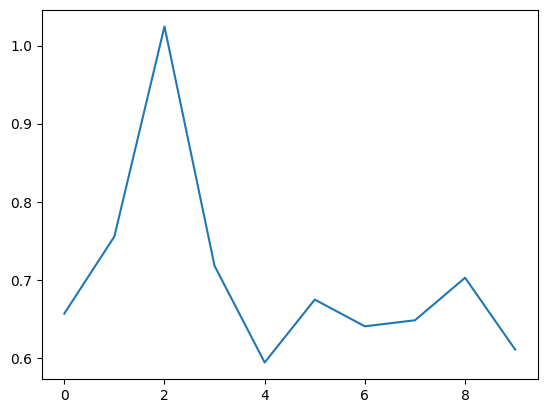

In [ ]:
list_loss = []
for epoch in range(10): # три полных прохода по нашим данным
    net.train() # обязательно переводим в режим обучения
    for data in trainset:  # `data` это батч наших данных
        X, y = data  # X это батч свойств, y это батч целевых переменных.
        #print(X)
        #print(y)
        net.zero_grad()  # устанавливаем значение градиента в 0 перед вычислением функции потерь. Вам следует делать это на каждом шаге.
        optimizer.zero_grad()
        output = net(X)  # передаем выпрямленный батч

        loss = loss_function(output, y.view(-1))  # вычисляем функцию потерь
        loss.backward()  # передаем это значение назад по сети
        optimizer.step()  # пытаемся оптимизировать значение весов исходя из потерь и градиента
        #print(output)
        #print(y.view(-1))
        #print('loss', loss)  # выводим на экран значение функции потерь. Мы надеемся, что оно убывает!

    print('loss', loss.item())  # выводим на экран значение функции потерь. Мы надеемся, что оно убывает!
    list_loss.append(loss.item())
print_roc_auc()

plt.plot(list_loss)
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

def predict_bin_clas_net(tset=testset):
  net.eval() # переводем модель в режим инференса
  outputs = []
  # показываем, что обученич нет и градиенты не обновляются
  with torch.no_grad():
    for data in tset:  # `data` это батч наших данных,
          X = data[0]  # X это батч свойств, y это батч целевых переменных.
          output = net(X).item()
          outputs.append(output)
  return outputs


def print_roc_auc():
  # Посмотрим  метрику  ROC-AUC
  roc_auc = roc_auc_score(y_true=y_test, y_score=predict_bin_clas_net())
  print(f"TEST:  ROC-AUC -- {roc_auc}")

In [ ]:
print_roc_auc()

TEST:  ROC-AUC -- 0.4867020851002545


In [ ]:
def save_array_to_submission(array, name='last_submission'):

    assert len(array) == 2000, 'shape doesnt match'
    print(array)

    df_subm = pd.DataFrame(array, columns=[0])

    df_subm.to_csv(f'{name}.csv', index=False, header=False)
    return 'ok'

In [ ]:
test_data = pd.read_csv('test.csv', header=None)

result_test_dataset = CSVDataset(x=test_data.values,
                                 y=y_test.values)
result_testset = torch.utils.data.DataLoader(result_test_dataset, batch_size=1, shuffle=False)

predict = predict_bin_clas_net(result_testset)


save_array_to_submission(predict, name='bc_net4')

[0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0, 0.9999996423721313, 0, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9995322227478027, 0, 0, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.0031979915220290422, 0.9999996423721313, 0.9999996423721313, 0, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.029347846284508705, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.899090051651001, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.999980092048645, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0, 0.9999996423721313, 0, 0.9993857145309448, 0.9999996423721313, 0, 0.9999996423721313, 0.9999996423721313, 0.9999996423721313, 0.9999996

'ok'

Итак, мы наглядно показали - даже небольшая полносвязанная сеть способна уже решать нетривиалные задачи и решать их крайне успешно.